# Research Question 4: What are the sustainability impacts associated with scaling the Superemulator (Here Energy Footprint)? 

In [1]:
pip install wandb

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: C:\Users\fe-na\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
pip install jinja2

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.comNote: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: C:\Users\fe-na\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
pip install scipy

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: C:\Users\fe-na\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [4]:
pip install seaborn

^C
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: C:\Users\fe-na\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [5]:
pip install pingouin

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: C:\Users\fe-na\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [6]:
import wandb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pandas as pd
import statistics


## Setup and Data Loading from Wandb

In [12]:
api = wandb.Api()
Baseline = api.runs(f"causalpaca/emulator", filters = {'group' : "Baseline", 'tags': "36_models"})
print(len(Baseline))
Model_36= api.runs(f"causalpaca/emulator", filters =  {'group' : "Final", 'tags': "36_models"})
All_data = api.runs(f"causalpaca/emulator", filters = {"$or": [
    {'group' : "Pin_Memory"}, 
    {'group' : "A100"},
    {'group' : "BatchSize_climax_frozen"},
    {'group' : "BatchSize_climax"},
    {'group' : "BatchSize_unet"},
    {'group' : "BatchSize_convlstm"},
    {'group' : "Baseline"},
    {'group' : "NW_convlstm"},
    {'group' : "NW_climax_frozen"},
    {'group' : "NW_climax"},
    {'group' : "NW_climax_unet"},
    {'group' : "Final"},
    {'group' : "97_Models"},
    {'group' : "MPT"},
    {'group' : "Shuffle"},
    ]})
print(len(All_data))
Treatments = [Baseline,Model_36]
Treatment_Names = ["Baseline_36","Final_36"]

8
127


In [41]:
def extract_parts_from_name(name):
    """
    Extracts parts from a given name.
    """
    parts = name.split('_')
    new_name = parts[1]
    if(parts[2]=="frozen"):
      new_name = new_name +"_"+ parts[2]
    return new_name

def filter_system_metrics(system_metrics, filter_criteria):
    """
    Filters system metrics based on specified criteria.
    """
    filtered_columns = [metric[0] for metric in filter_criteria]

    return system_metrics[filtered_columns]


data = []
for index, treatment in enumerate(Treatments):

  for model in treatment:
      # Fetching metrics for the specified run
      try: 
        name = model.config["model"]["model_name"]
      except:
        name = model.config["model/model_name"]

      # Retrieving system metrics history
      system_metrics = model.history(stream="systemMetrics")
      filter_criteria = [
          ['system.cpu'],
          ['system.gpu.process.0.powerWatts'],
          ['system.proc.memory.rssMB'],
      ]
      # Filtering system metrics based on the specified criteria
      system_metrics_filtered = filter_system_metrics(system_metrics, filter_criteria)

      defaults = model.history()

      # Scanning history for default metrics
      default_metrics = model.scan_history()
      default_metrics_df = pd.DataFrame(default_metrics)
      still_running = False

      try:
        # Extract the required columns
        val_rmse = default_metrics_df['val/rmse'].ffill()
        val_rmse = val_rmse.bfill().tolist()
        emissions = default_metrics_df['emissions'].dropna().tolist()[0]
        steps = default_metrics_df['_step'].tolist()
      except:
        still_running = True

      if(still_running):
        continue

      # Creating DataFrame for the filtered default metrics and steps
      #val_rmse_df = pd.DataFrame({'val/rmse': val_rmse}).fillna(method='ffill')

      # Extracting runtime values from system metrics
      runtime_values = system_metrics['_runtime']

      print(name,Treatment_Names[index])
      runtime_hours = model.summary["_wandb"].runtime / 60 / 60
      # Create a new DataFrame for the current row
      data.append({
        "treatment": Treatment_Names[index],
        "name": name,
        "Steps": steps,
        "runtime_hours": runtime_hours,
        "GPU_Power_Watts": system_metrics_filtered['system.gpu.process.0.powerWatts'].dropna().to_list(),
        "Co2": emissions*100, #for 100 Epochs
      })
# Convert the list of dictionaries to a DataFrame


convlstm Baseline_36
climax_frozen Baseline_36
unet Baseline_36
climax Baseline_36
unet Baseline_36
convlstm Baseline_36
climax_frozen Baseline_36
climax Baseline_36
convlstm Final_36
unet Final_36
climax_frozen Final_36
climax Final_36
convlstm Final_36
unet Final_36
climax_frozen Final_36
climax Final_36
climax Final_36
climax_frozen Final_36
convlstm Final_36
unet Final_36


In [42]:
runs_count = {}
for d in data:
    key = (d["name"], d["treatment"])
    runs_count[key] = runs_count.get(key, 0) + 1
print(runs_count)

{('convlstm', 'Baseline_36'): 2, ('climax_frozen', 'Baseline_36'): 2, ('unet', 'Baseline_36'): 2, ('climax', 'Baseline_36'): 2, ('convlstm', 'Final_36'): 3, ('unet', 'Final_36'): 3, ('climax_frozen', 'Final_36'): 3, ('climax', 'Final_36'): 3}


In [49]:
# Merge the Multiples
mean_data = {}
data_scheme={
    "CPU": [],
    "GPU": [],
    "GPU_Power_Watts": [],
    "RMSE": 0,
    "Steps": [],
    "runtime_hours": 0,
    "Co2": 0
}

for run in runs_count: 
    number_runs = runs_count.get((run[0], run[1]),0)
    print(run)
    CPU_Lists=[]
    GPU_Lists=[]
    Power=[]
    RMSE_Lists=[]
    Steps_Lists=[]
    Runtime_Lists=[]
    CO2_Lists=[]
    
    for d in data: 
        if d["name"] == run[0] and d["treatment"] == run[1]:
            print(run[0],run[1])
            Power.append(d["GPU_Power_Watts"])
            Steps_Lists.append(d["Steps"])
            CO2_Lists.append(d["Co2"])
            Runtime_Lists.append(d["runtime_hours"])
    
    # if (number_runs>=2):
    print(len(Power))
    if (number_runs>=2):
        mean_data[(run[0], run[1])] = {
            "GPU_Power_Watts": [(x + y)/2 for x, y in zip(Power[0], Power[1])],
            "Steps": [(x + y)/2 for x, y in zip(Steps_Lists[0], Steps_Lists[1])],
            "Co2": statistics.mean(CO2_Lists),
            "runtime_hours": statistics.mean(Runtime_Lists)
        }
    else:
        print("skipped")

print(mean_data)

('convlstm', 'Baseline_36')
convlstm Baseline_36
convlstm Baseline_36
2
('climax_frozen', 'Baseline_36')
climax_frozen Baseline_36
climax_frozen Baseline_36
2
('unet', 'Baseline_36')
unet Baseline_36
unet Baseline_36
2
('climax', 'Baseline_36')
climax Baseline_36
climax Baseline_36
2
('convlstm', 'Final_36')
convlstm Final_36
convlstm Final_36
convlstm Final_36
3
('unet', 'Final_36')
unet Final_36
unet Final_36
unet Final_36
3
('climax_frozen', 'Final_36')
climax_frozen Final_36
climax_frozen Final_36
climax_frozen Final_36
3
('climax', 'Final_36')
climax Final_36
climax Final_36
climax Final_36
3
{('convlstm', 'Baseline_36'): {'GPU_Power_Watts': [51.19, 39.379999999999995, 61.8, 61.705, 65.675, 100.29, 102.36, 107.72, 115.455, 112.645, 115.16999999999999, 114.11500000000001, 100.935, 115.13000000000001, 107.625, 111.745, 116.44999999999999, 108.77000000000001, 107.69, 111.705, 115.57, 112.97999999999999, 121.385, 113.66499999999999, 110.20500000000001, 114.03, 102.21, 113.425, 108.414

## Overview of Mean, Median and STD

In [58]:
data_scheme={
    "CPU": [],
    "GPU": [],
    "GPU_Power_Watts": [],
    "RMSE": 0,
    "Steps": [],
    "runtime_hours": 0,
    "Co2": 0
}

kwh_charging_phone = 0.022
paper_iso_14040_14044_KG = 4.64/1000
mature_tree_absorbtion_day = 22/365

rows = []
for run in runs_count: 
    number_runs = runs_count.get((run[0], run[1]),0)
    if(number_runs>=2):
        name = run[0]
        treatment = run[1]
        data_for_run = mean_data.get((run[0], run[1]),0)
        new_row = {
            "Name":name, 
            "Treatment":treatment, 
            "GPU_Power_Watts": statistics.mean(data_for_run["GPU_Power_Watts"]),
            "GPU_KWH": (statistics.mean(data_for_run["GPU_Power_Watts"])/1000)*data_for_run["runtime_hours"],
            #"GPW_Integral": np.trapz(data_for_run['GPU_Power_Watts'], dx=1),
            "Smartphone Charges": (statistics.mean(data_for_run["GPU_Power_Watts"])/1000)*data_for_run["runtime_hours"]/kwh_charging_phone,
            "Co2": data_for_run["Co2"],
            "Sheets of Paper": data_for_run["Co2"]/paper_iso_14040_14044_KG,
            "Time to absorb for Mature Tree": data_for_run["Co2"]/mature_tree_absorbtion_day,
            "runtime_hours": data_for_run["runtime_hours"]}
        
        rows.append(new_row)


already_used_name=[]
scaling_factor_rows = []
for run in runs_count: 
    number_runs = runs_count.get((run[0], run[1]), 0)
    if(number_runs >= 2 and (run[0] not in already_used_name)):
        already_used_name.append(run[0])
        name = run[0]
        treatment_0 = Treatment_Names[0]
        treatment_1 = Treatment_Names[1]

        data_for_run_0 = mean_data.get((run[0], treatment_0), 0)
        data_for_run_1 = mean_data.get((run[0], treatment_1), 0)
        new_row = {
            "Name":name, 
            "Treatment":treatment, 
            "GPU_Power_Watts": statistics.mean(data_for_run["GPU_Power_Watts"]),
            "runtime_hours": data_for_run["runtime_hours"],
            "Co2": data_for_run["Co2"]}
        
        new_row_scaling = {
            "Name":name, 
            "GPU_Power_Watts": statistics.mean(data_for_run_1["GPU_Power_Watts"])/statistics.mean(data_for_run_0["GPU_Power_Watts"]),
            "Co2": data_for_run_1["Co2"]/data_for_run_0["Co2"]}
        
        scaling_factor_rows.append(new_row)

new_df = pd.DataFrame(rows)
new_df_sf = pd.DataFrame(scaling_factor_rows)
sorted_df = new_df.sort_values(by='Name')
sorted_df_sf = new_df_sf.sort_values(by='Name')
def round_if_float(x):
    if isinstance(x, float):
        rounded_value = round(x, 3)
        return rounded_value
    return x
sorted_df = sorted_df.applymap(round_if_float)
sorted_df_sf = sorted_df_sf.applymap(round_if_float)

latex_table = sorted_df.to_latex(index=False,float_format="%.3f")
latex_table_sf = sorted_df_sf.to_latex(index=False,float_format="%.3f")

print(latex_table)
#print(latex_table_sf)



\begin{tabular}{llrrrrrrr}
\toprule
Name & Treatment & GPU_Power_Watts & GPU_KWH & Smartphone Charges & Co2 & Sheets of Paper & Time to absorb for Mature Tree & runtime_hours \\
\midrule
climax & Baseline_36 & 180.315 & 3.819 & 173.596 & 1.474 & 317.611 & 24.450 & 21.180 \\
climax & Final_36 & 101.734 & 1.032 & 46.925 & 0.680 & 146.481 & 11.276 & 10.147 \\
climax_frozen & Baseline_36 & 157.185 & 2.578 & 117.167 & 1.056 & 227.624 & 17.523 & 16.399 \\
climax_frozen & Final_36 & 101.049 & 0.955 & 43.431 & 0.645 & 139.113 & 10.709 & 9.456 \\
convlstm & Baseline_36 & 103.765 & 0.231 & 10.490 & 0.120 & 25.906 & 1.994 & 2.224 \\
convlstm & Final_36 & 83.495 & 0.130 & 5.891 & 0.093 & 20.144 & 1.551 & 1.552 \\
unet & Baseline_36 & 241.632 & 1.999 & 90.842 & 0.763 & 164.401 & 12.656 & 8.271 \\
unet & Final_36 & 196.190 & 0.500 & 22.715 & 0.219 & 47.162 & 3.631 & 2.547 \\
\bottomrule
\end{tabular}



C:\Users\fe-na\AppData\Local\Temp\ipykernel_19400\1812753523.py:72: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sorted_df = sorted_df.applymap(round_if_float)
C:\Users\fe-na\AppData\Local\Temp\ipykernel_19400\1812753523.py:73: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sorted_df_sf = sorted_df_sf.applymap(round_if_float)


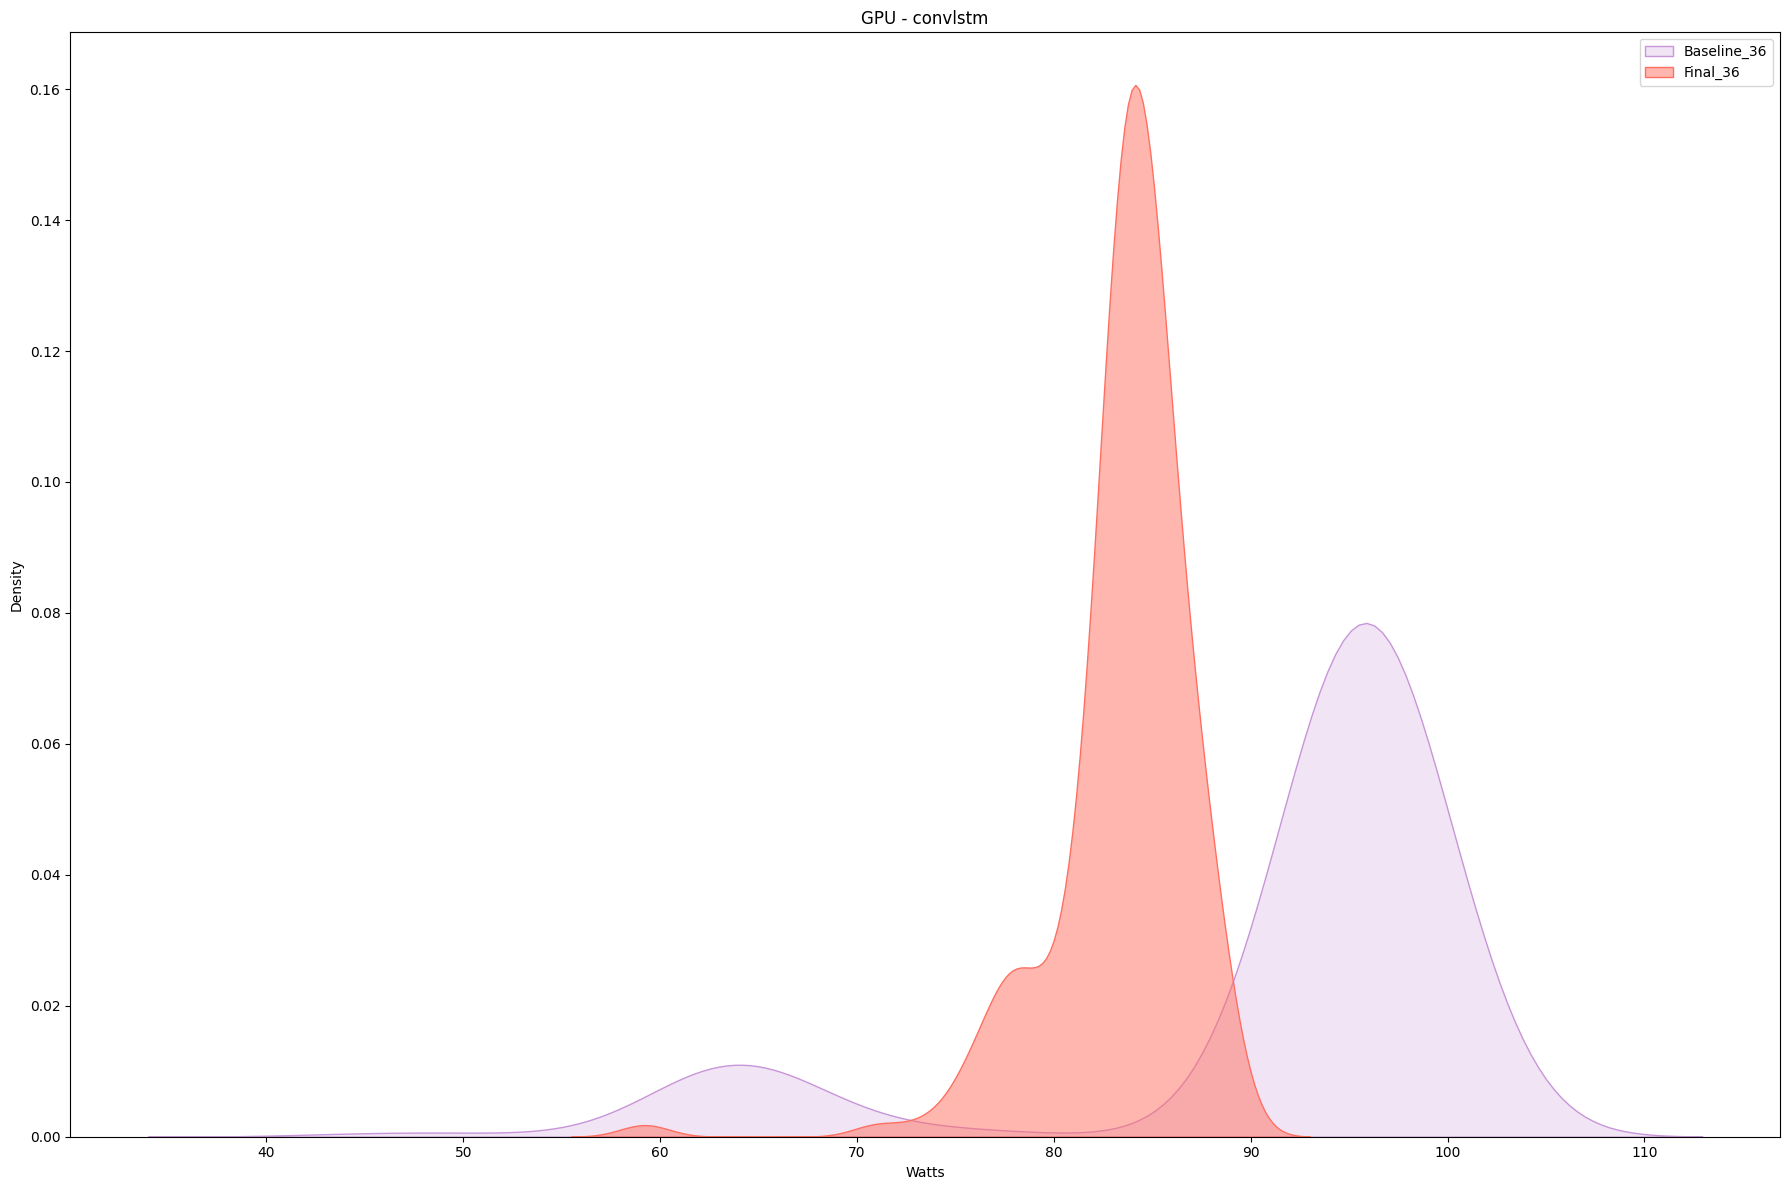

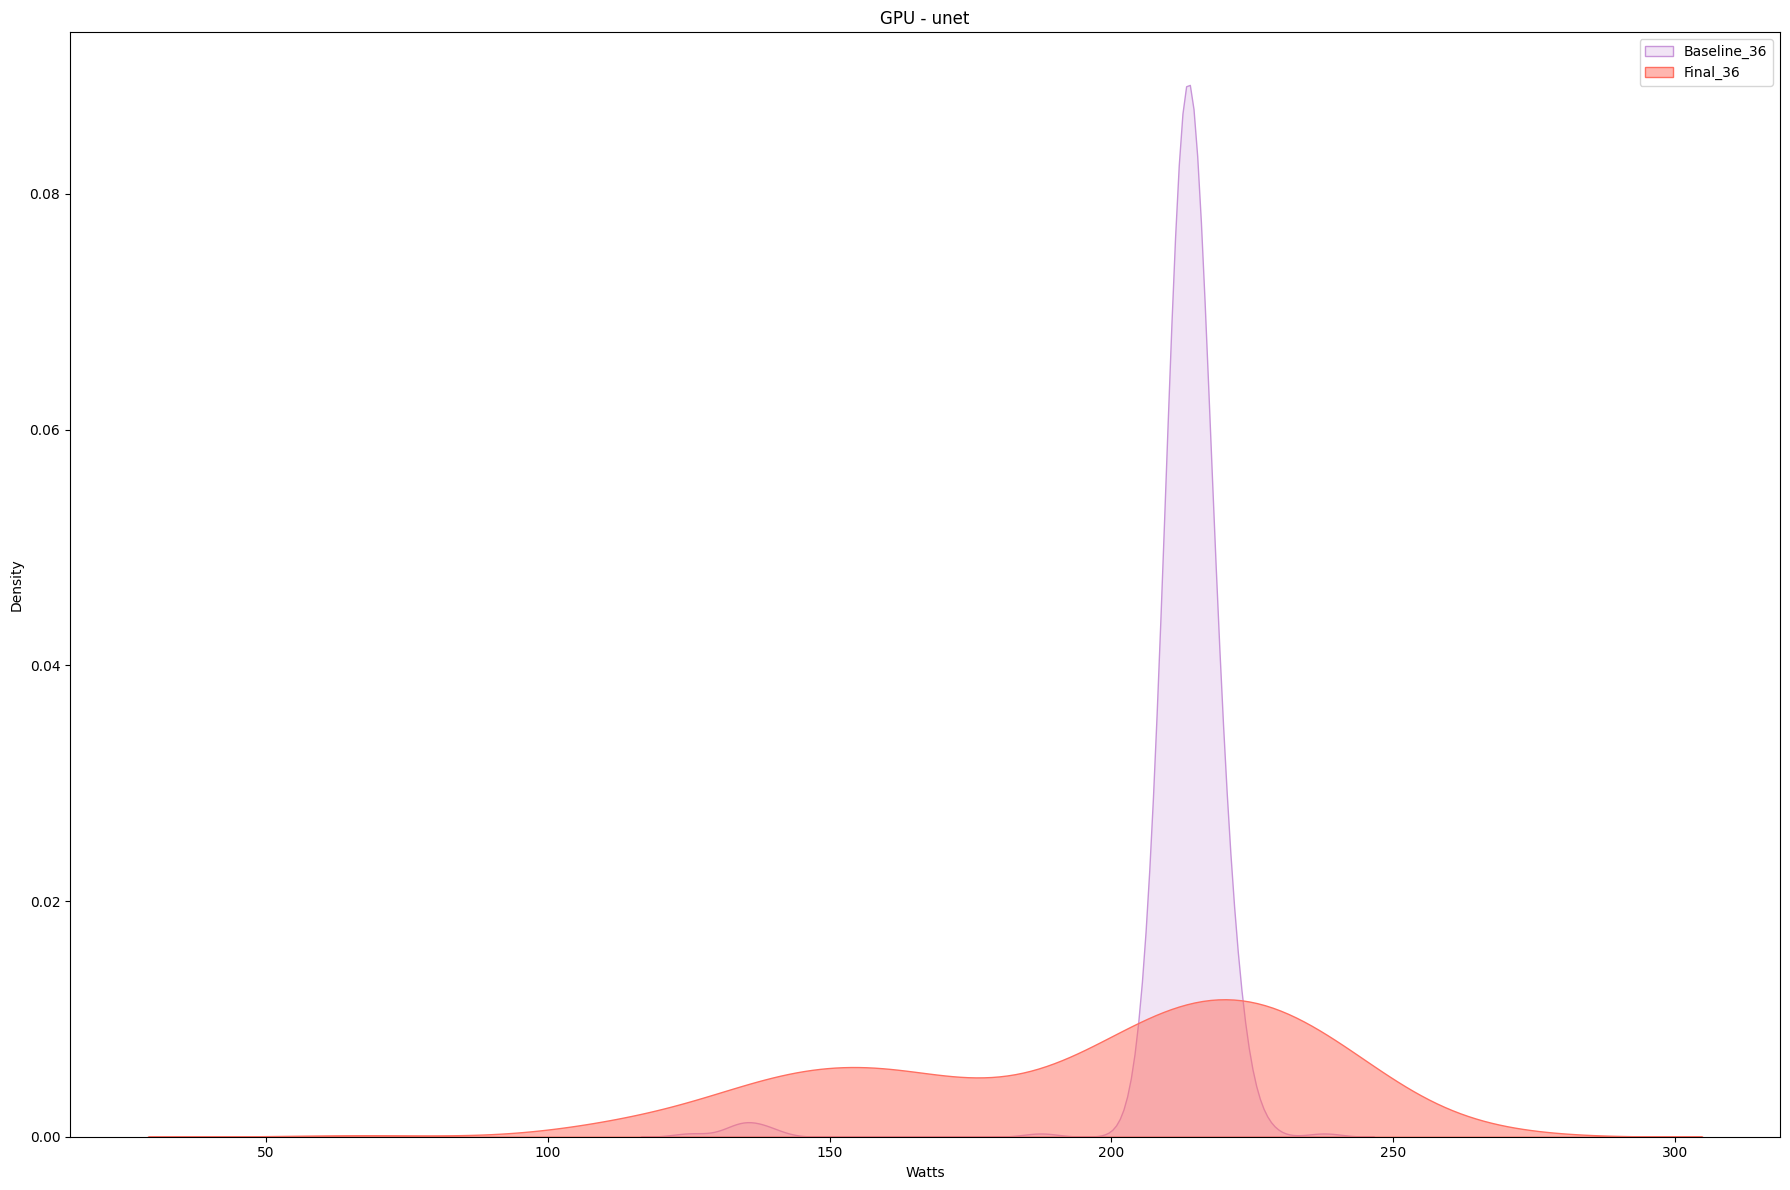

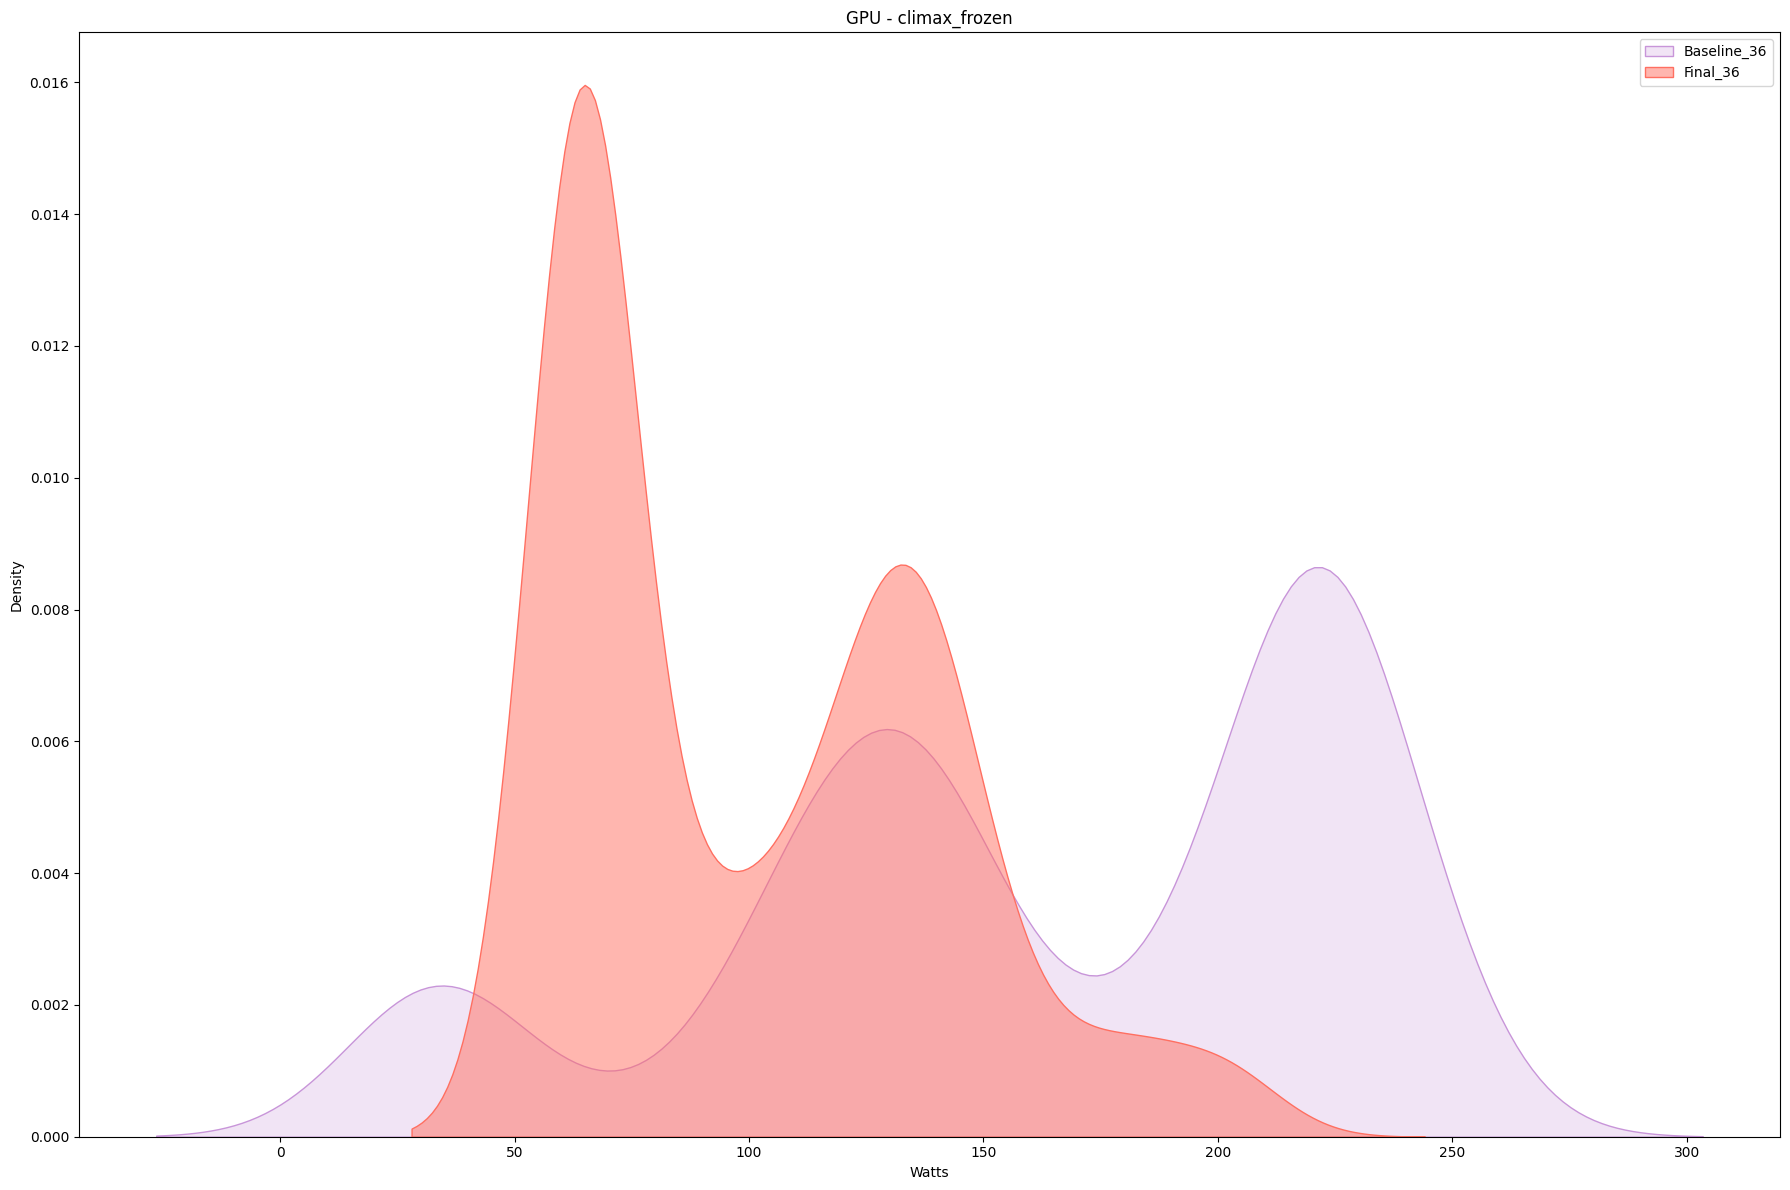

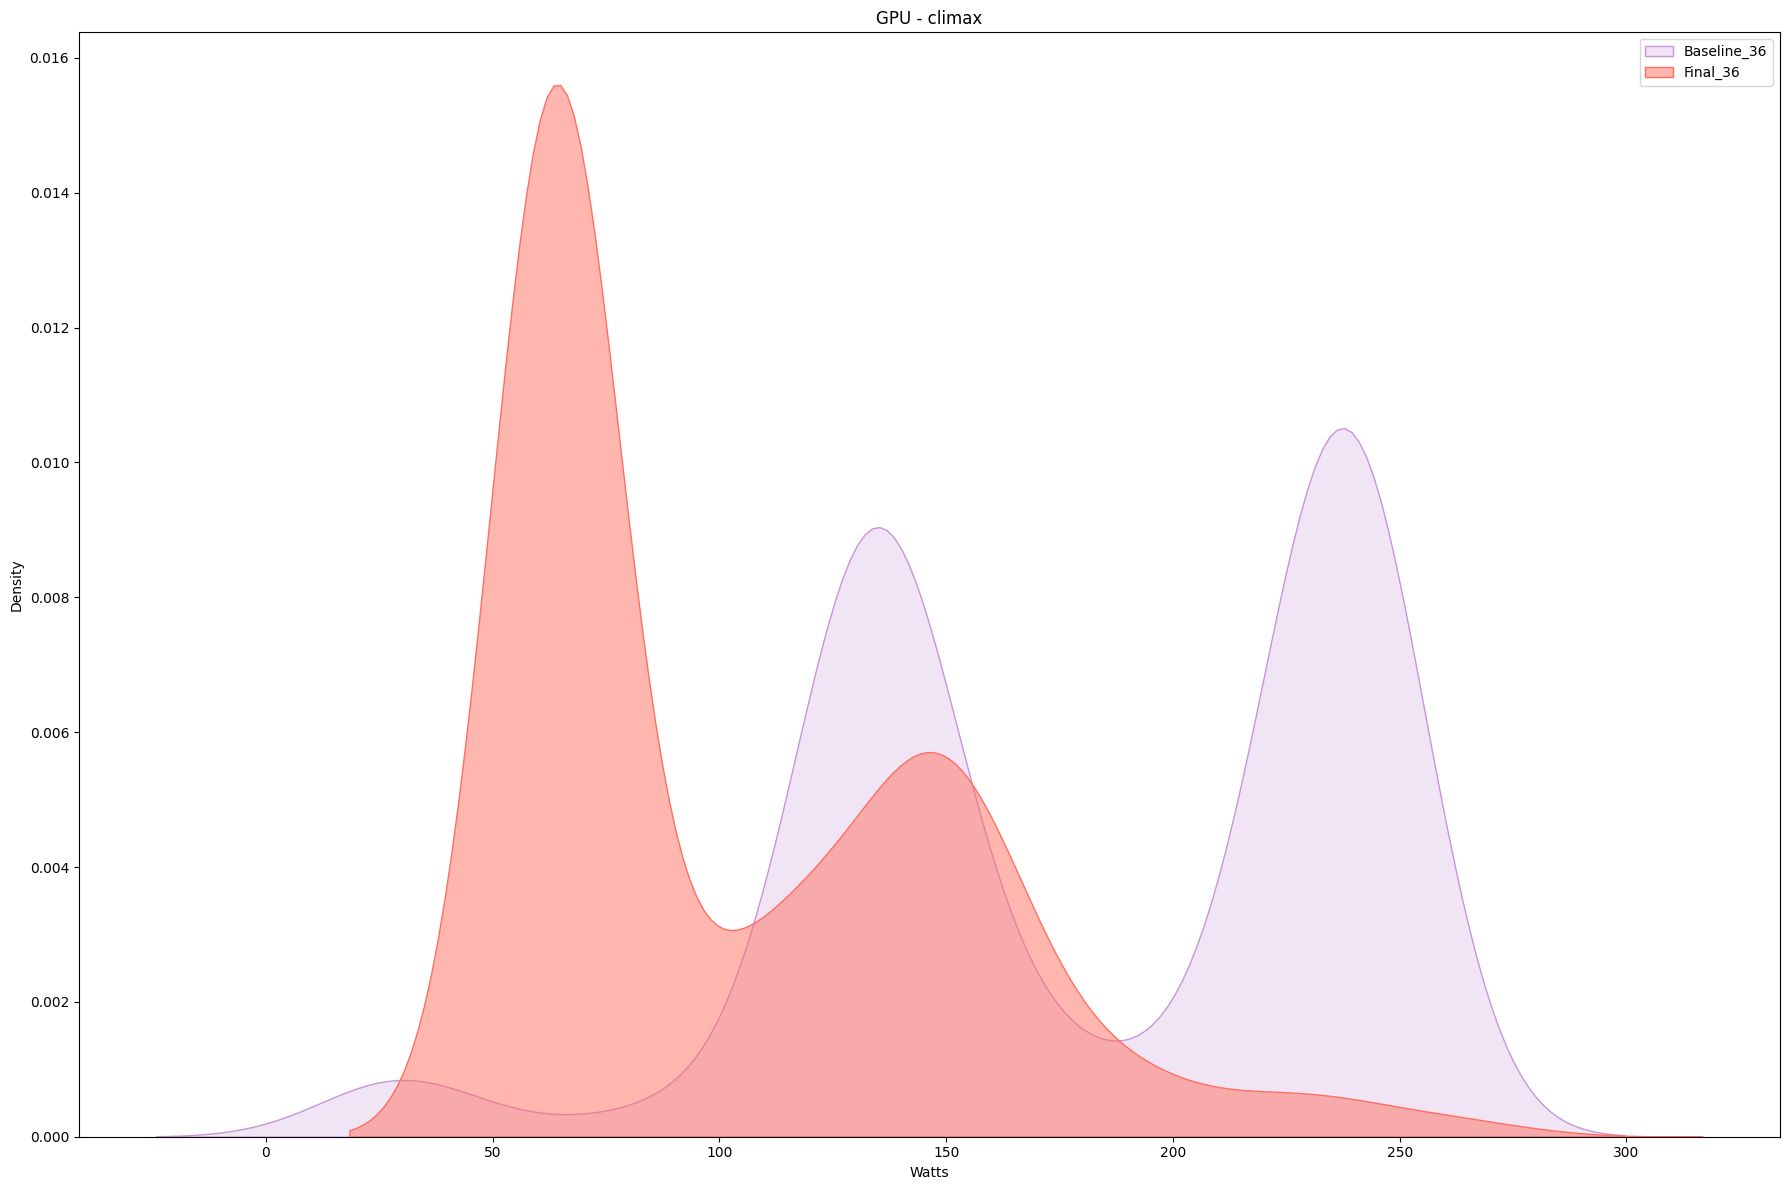

In [36]:
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from seaborn_qqplot import pplot
from scipy.stats import gamma
from PIL import Image
import statsmodels.api as sm 
import pylab as py 



def violin_plot(ax, data, name, unit):
    sns.violinplot(data=data, ax=ax, inner="box", color="#c895d9")
    ax.set_title(name)
    ax.set_xlabel("Data Distribution")
    ax.set_ylabel(unit)

def density_plot(ax, data, name, unit):
    sns.kdeplot(data=data, fill=True, color="#c895d9", ax=ax)
    ax.set_title(name)
    ax.set_xlabel(unit)
    ax.set_ylabel("Density")


def qq_plot(data, name, line_color="#c895d9"):
    # multirow = [{"Theoretical_Quantiles":np.array((stats.norm.ppf(np.arange(1, len(data)+1) / (len(data)+1))),dtype=float), "species":0}]
    # df = pd.DataFrame(multirow)
    # df_new = df.explode("Theoretical_Quantiles").astype(float)
    # # Plot the quantiles
    # pairGrid = pplot(df_new, x="Theoretical_Quantiles",y=gamma, kind='qq', height=5, aspect=1, display_kws={"identity":False, "fit":True, "reg":True, "ci":0.025})
    # pairGrid.add_legend(title=name)
    # pairGrid.figure.savefig(f"figures/{name}")
    data_points = np.random.normal(0, 1, 100)     
    sm.qqplot(data, line ='45') 
    py.show()
    
    

def density_plot_2(ax, treatment6, treatment36, name, unit):
    sns.kdeplot(data=treatment6, fill=True, color="#c895d9", ax=ax, label='Baseline_36')
    sns.kdeplot(data=treatment36, fill=True, color="#ff6f61", ax=ax, alpha=0.5, label='Final_36')
    ax.set_title(name)
    ax.set_xlabel(unit)
    ax.set_ylabel("Density")
    ax.legend()

def scale_down(data,factor=6.0):
    new_data = []
    for x in data:
        new_x = x / factor
        new_data.append(new_x)
    return new_data
        

############################################ VIOLIN & DENSITY PLOTS ############################################################

# for run in runs_count: 
#     number_runs = runs_count.get((run[0], run[1]), 0)
#     if number_runs >= 2:
#         name = run[0]
#         treatment = run[1]
#         data_for_run = mean_data.get((run[0], run[1]), 0)
        
#         fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # Create a 2x3 grid of subplots
        
#         violin_plot(axes[0, 0], data_for_run["GPU"], f"GPU - {run[0]}-{run[1]}", "Percent")
#         violin_plot(axes[0, 1], data_for_run["CPU"], f"CPU - {run[0]}-{run[1]}", "Percent")
#         violin_plot(axes[0, 2], data_for_run["GPU_Power_Watts"], f"RSS-Memory - {run[0]}-{run[1]}", "GB")
        
#         density_plot(axes[1, 0], data_for_run["GPU"], f"GPU - {run[0]}-{run[1]}", "Percent")
#         density_plot(axes[1, 1], data_for_run["CPU"], f"CPU - {run[0]}-{run[1]}", "Percent")
#         density_plot(axes[1, 2], data_for_run["GPU_Power_Watts"], f"RSS-Memory - {run[0]}-{run[1]}", "GB")
        
#         plt.tight_layout()
#         plt.show()

############################################ QQ PLOTS ############################################################
# for run in runs_count: 
#     number_runs = runs_count.get((run[0], run[1]), 0)
#     if number_runs >= 2:
#         name = run[0]
#         treatment = run[1]
#         data_for_run = mean_data.get((run[0], run[1]), 0)


#         qq_plot(data_for_run["GPU"], f"GPU - {run[0]}-{run[1]}")
#         qq_plot(data_for_run["CPU"], f"CPU - {run[0]}-{run[1]}")
#         qq_plot(data_for_run["GPU_Power_Watts"], f"RSS-Memory - {run[0]}-{run[1]}")

#         images = [Image.open(x) for x in [f"figures/GPU - {run[0]}-{run[1]}.png", f"figures/CPU - {run[0]}-{run[1]}.png", f"figures/RSS-Memory - {run[0]}-{run[1]}.png"]]
#         widths, heights = zip(*(i.size for i in images))

#         total_width = sum(widths)
#         max_height = max(heights)

#         new_im = Image.new('RGB', (total_width, max_height))

#         x_offset = 0
#         for im in images:
#             new_im.paste(im, (x_offset,0))
#             x_offset += im.size[0]

#         new_im.save(f'figures/combined_figs/{run[0]}-{run[1]}.png')
#          # will now save all plots

############################################ COMBINED DENSITY PLOTS ############################################################


already_used_name=[]
for run in runs_count: 
    number_runs = runs_count.get((run[0], run[1]), 0)
    if(number_runs >= 2 and (run[0] not in already_used_name)):
        already_used_name.append(run[0])
        name = run[0]
        treatment_0 = Treatment_Names[0]
        treatment_1 = Treatment_Names[1]

        data_for_run_0 = mean_data.get((run[0], treatment_0), 0)
        data_for_run_1 = mean_data.get((run[0], treatment_1), 0)

        

        fig, axes = plt.subplots(1, 1, figsize=(18, 12))  # Create a 2x3 grid of subplots

        density_plot_2(axes, data_for_run_0["GPU_Power_Watts"],data_for_run_1["GPU_Power_Watts"], f"GPU - {run[0]}", "Watts")
        # density_plot_2(axes[1], data_for_run_0["CPU"],data_for_run_1["CPU"], f"CPU - {run[0]}", "Percent")
        # density_plot_2(axes[2], data_for_run_0["GPU_Power_Watts"],data_for_run_1["GPU_Power_Watts"], f"RSS-Memory - {run[0]}-{run[1]}", "GB")
        
        plt.tight_layout()
        plt.show()





            Name    Treatment  \
3         climax  Baseline_36   
7         climax     Final_36   
2  climax_frozen  Baseline_36   
6  climax_frozen     Final_36   
0       convlstm  Baseline_36   
4       convlstm     Final_36   
1           unet  Baseline_36   
5           unet     Final_36   

                                     GPU_Power_Watts  GPW_Integral    Co2  
3  [151.6, 168.11, 133.34, 135.01000000000002, 24...     84649.260  1.474  
7  [60.89, 151.405, 172.39, 111.82499999999999, 6...     45962.842  0.680  
2  [30.305, 225.18, 228.5, 222.35, 122.005, 31.61...     77175.765  1.056  
6  [71.06, 126.88, 99.89500000000001, 63.495, 63....     47778.637  0.645  
0  [45.215, 50.605000000000004, 66.73, 61.56, 62....     24070.432  0.127  
4  [59.22, 71.06, 78.88499999999999, 77.860000000...     14962.730  0.093  
1  [138.53, 237.76, 224.85, 223.49, 226.005, 216....    104368.137  0.734  
5  [67.255, 200.91, 238.57999999999998, 191.64499...     49138.425  0.219  
3     84649.260
7 

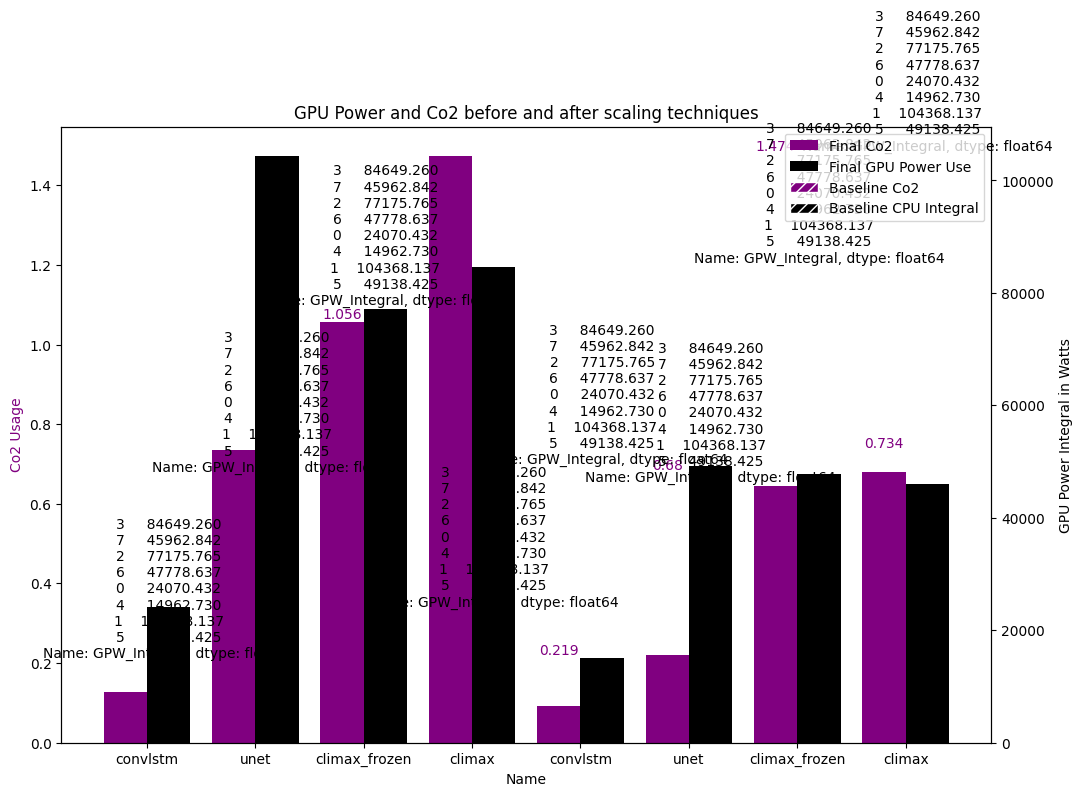

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your dataframe
df = sorted_df
print(df)
# Set up the plot
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot the Time/Train Mean_Minutes with dashed bars for Treatment == 2
ax1.set_xlabel('Name')
ax1.set_ylabel('Co2 Usage', color='purple')
bars1 = ax1.bar(df.index - 0.2, df['Co2'], width=0.4, label='Co2 in Kg', color='purple')
for i, bar in enumerate(bars1):
    if df['Treatment'][i] == "Baseline":
        bar.set_hatch('/')
        bar.set_edgecolor("white")

# Create a second y-axis for RMSE
ax2 = ax1.twinx()
ax2.set_ylabel('GPU Power Integral in Watts', color='black')
print(df['GPW_Integral'])
bars2 = ax2.bar(df.index + 0.2, df['GPW_Integral'], width=0.4, label='GPU Power Usage in Watts', color='black')
for i, bar in enumerate(bars2):
    if df['Treatment'][i] == "Baseline":
        bar.set_hatch('/')
        bar.set_edgecolor("white")

# Adding names as x-axis labels
ax1.set_xticks(df.index)
ax1.set_xticklabels(df['Name'])

# Annotate the bars with Treatment values
for i in range(len(df)):
    ax1.text(df.index[i] - 0.2, df['Co2'][i]*1.01, str(df['Co2'][i]), ha='center', color='purple')
    ax2.text(df.index[i] + 0.2, df['GPW_Integral'][i] *1.01, str(df['GPW_Integral']), ha='center', color='black')

# Add legend with grouped labels
purple_patch = plt.Rectangle((0, 0), 1, 1, fc="purple", hatch="")
black_patch = plt.Rectangle((0, 0), 1, 1, fc="black", hatch="")
dashed_purple_patch = plt.Rectangle((0, 0), 1, 1, fc="purple",edgecolor="white", hatch="///")
dashed_black_patch = plt.Rectangle((0, 0), 1, 1, fc="black",edgecolor="white", hatch="///")

# dashed_purple_patch = plt.Line2D([], [], color="purple", marker='', linestyle='None', markersize=10, markerfacecolor='white', label='Baseline Time')
# dashed_black_patch = plt.Line2D([], [], color="black", marker='', linestyle='None', markersize=10, markerfacecolor='white', label='Baseline RMSE')
plt.legend(handles=[purple_patch, black_patch, dashed_purple_patch, dashed_black_patch],
           labels=['Final Co2', 'Final GPU Power Use', 'Baseline Co2', 'Baseline CPU Integral'], loc='upper right')
plt.title('GPU Power and Co2 before and after scaling techniques')

# Save the figure
fig.savefig("figures/RQ_4_combined_bar/RQ_4_combined_bar.png")

# Show plot
plt.show()


\begin{tabular}{lrrrrrrrrrrrr}
\toprule
Name & GPU-Statistic-RS & GPU-P-RS & GPU-Statistic-KS & GPU-P-KS & CPU-Statistic-RS & CPU-P-RS & CPU-Statistic-KS & CPU-P-KS & RSS-Statistic-RS & RSS-P-RS & RSS-Statistic-KS & RSS-P-KS \\
\midrule
climax & 27.018891 & 0.000000 & 1.000000 & 0.000000 & 23.051978 & 0.000000 & 0.893617 & 0.000000 & 16.953985 & 0.000000 & 0.593789 & 0.000000 \\
climax_frozen & 24.489629 & 0.000000 & 1.000000 & 0.000000 & 21.399257 & 0.000000 & 0.908815 & 0.000000 & 15.659275 & 0.000000 & 0.525710 & 0.000000 \\
convlstm & 9.369098 & 0.000000 & 1.000000 & 0.000000 & 9.365079 & 0.000000 & 1.000000 & 0.000000 & 8.807678 & 0.000000 & 0.969697 & 0.000000 \\
unet & 18.864556 & 0.000000 & 1.000000 & 0.000000 & 18.799894 & 0.000000 & 1.000000 & 0.000000 & 18.631099 & 0.000000 & 0.993671 & 0.000000 \\
\bottomrule
\end{tabular}

